In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mlp
import MultiLayerDQTF as dq
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm
from scipy.stats import norm

# Model expectation and uncertainty

In [2]:
def pred_ints(model,X_list,mdtype):
    if(mdtype=="RF"):
        est_num = len(model.estimators_)
        preds = np.zeros((est_num,len(X_list)))
        for i,pred in enumerate(model.estimators_):
            preds[i] = pred.predict(X_list)

        means = np.mean(preds,axis=0)
        std = np.std(preds,axis=0)
    elif(mdtype=="GP"):
        means,std = model.predict(X_list,return_std=True)
    return means, std
        

# Metrics typically used on heuristics

In [3]:
def FunRandom(x,model,fstar):
    return np.random.uniform(size=len(x))

def Greedy(x_list,model,fstar):
    return model.predict(x_list)

def UCB(x_list,model,fstar,beta=2,mdl='GP'):
    mu,sigma = pred_ints(model,x_list,mdtype=mdl)
    return mu+beta*sigma

def gamma(x_list,model,fstar,epsilon=0.01):
    return model.predict(x_list)-fstar+epsilon

def z(x_list,model,fstar,mdl='GP'):
    mu, sigma = pred_ints(model,x_list,mdtype=mdl)
    return gamma(x_list,model,fstar)/sigma

def EI(x_list,model, fstar,mdl='GP'):
    mu, sigma = pred_ints(model,x_list,mdtype=mdl)
    zl = z(x_list,model,fstar)
    eis = np.zeros_like(mu)
    gl = gamma(x_list,model,fstar)
    for i,gam,zz,ss in zip(list(range(len(mu))),gl,zl,sigma):
        if(ss>0):
            eis[i] = gam*norm.cdf(zz)+ss*norm.pdf(zz)
        else:
            eis[i] = gam
    return eis
    
def PI(x_list,model,fstar,mdl='GP'):
    mu,sigma = pred_ints(model,x_list,mdtype=mdl)
    zl = z(x_list,model,fstar)
    gam = gamma(x_list,model,fstar)
    ppi = np.zeros_like(mu)
    for i,gg,ss,zz in zip(list(range(len(x_list))),gam,sigma,zl):
        if(ss>0):
            ppi[i] = norm.cdf(zz)
        else:
            if(gg>0):
                ppi[i]=1
            else:
                ppi[i]=0
    return ppi

# Obtain the simulated data set

In [4]:
seeds = [658, 682]
NUMBER_SAMPLES = 5000
X_train, y_train = make_regression(n_samples=NUMBER_SAMPLES,n_features=2,n_informative=3,n_targets=1,noise=0.0)
fstar = np.percentile(y_train,90)
NEP = 10
BUDGET = 100
BATCH_SIZE = 35

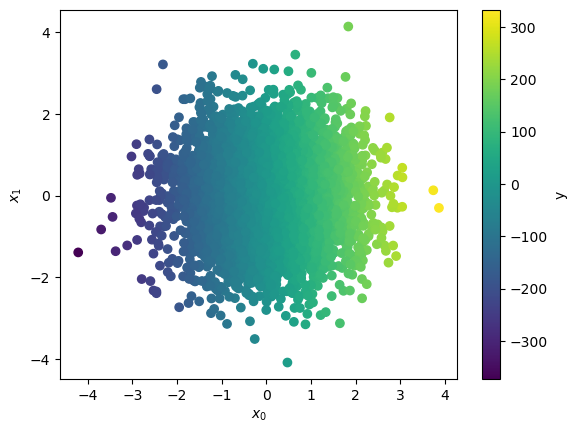

In [5]:
im = plt.scatter(X_train[:,0],X_train[:,1],c=y_train)
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.colorbar(im,label='y')

# Define the greedy parameters for the extra features of the state

In [6]:
# Greedy sampling function on feature space (just distance to nearest neighboor)
def GS_x(x,x_list):
    distances = np.zeros_like(x_list)

    for ii,xx in enumerate(x_list):
        distances[ii] = np.sqrt(np.sum((x-xx)**2))
    
    return np.min(distances)

def GS_y(x,y_init,model):
    Ypreds = model.predict([x])
    distances =  np.zeros_like(y_init)
    for ii, xx in enumerate(y_init):
        distances[ii] = np.abs(Ypreds-xx)
    return np.min(distances)

def state(model,cand,pool_xs,pool_vals):
    gsx = GS_x(cand,pool_xs)
    gsy = GS_y(cand,pool_vals,model)
    return tf.cast(np.array([[*cand,gsx,gsy]]).reshape(1,-1),dtype=tf.float32)

def state_her(model,cand,fstar,mdl='GP'):
    pred, uncert = pred_ints(model,[cand],mdtype=mdl)
    Pi_v = PI([cand],model,fstar)
    UCB_v = UCB([cand],model,fstar,beta=2)
    return tf.cast(np.array([*cand,*pred,*uncert,*Pi_v,*UCB_v]).reshape(1,-1),dtype=tf.float32)


# Testing the ability of the surrogate model

In [32]:
x_held, y_held = X_train[:100], y_train[:100]
x_o, y_o = X_train[100:300], y_train[100:300]

model1 = RandomForestRegressor(100, n_jobs=-2,random_state=158)
model2 = MLPRegressor((256,256),random_state=123)
model3 = GaussianProcessRegressor()

In [37]:
model3.predict(x_held,return_std=True)

(array([   4.43755945,    3.82545827,   -3.88563799,   40.74810358,
          19.91262322,  -43.08299849,   46.20599324,  -15.70951991,
          26.27276932,   42.70270885,  -51.19055186,  -40.9696834 ,
          19.61877774,  -73.31926235,   22.19446204,  -19.77131359,
          20.63216205,    6.17058905,  -16.38375374,   72.42702642,
          -2.67416749,   -0.41665361,  -10.60561319,   11.50895121,
         -14.1445818 ,   59.75824458,  -38.19851725,   66.61377713,
         -35.21065154,  -24.89803722,   18.54894825, -102.70405368,
          22.17042803,   34.68585591,   32.00669462,   38.64254437,
          88.69373848,   54.1925096 ,  -17.7638972 ,   87.03768973,
         -44.25785007,   52.56737017,  -11.67697222,  -51.94350973,
         -17.36351144,   16.57560397,    6.93791682,   51.3299574 ,
          26.65051925,  -51.03553891,   18.70345941,   58.72509511,
         -12.38908963,   -9.54699686,   11.53744519,   16.8564433 ,
           6.8114433 ,  -17.80089782,  -69.50884

In [33]:
model1.fit(x_o,y_o)
model2.fit(x_o,y_o)
model3.fit(x_o,y_o)

/Users/tingua/miniforge3/envs/py38tf/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


GaussianProcessRegressor()

In [34]:
ypred = model1.predict(x_held)
error = mean_squared_error(y_held,ypred)
print(error)
ypred = model2.predict(x_held)
error = mean_squared_error(y_held,ypred)
print(error)
ypred = model3.predict(x_held)
error = mean_squared_error(y_held,ypred)
print(error)

104.26583148465505
3.2295973926719252
2.9705487188268136


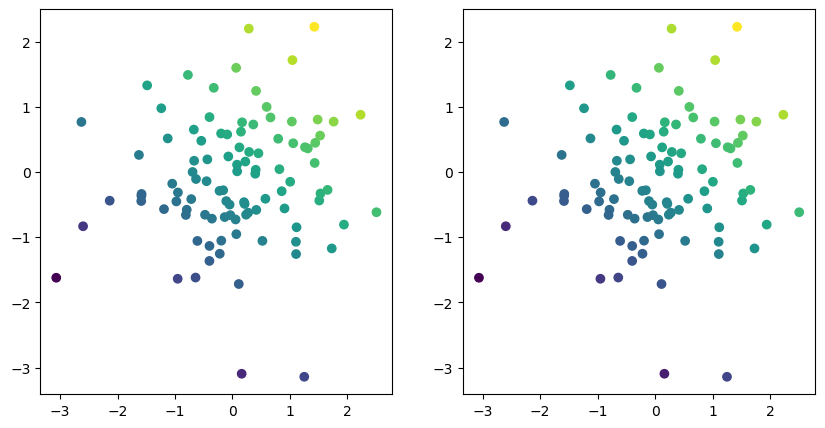

In [36]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(x_held[:,0],x_held[:,1],c=y_held)
ax[1].scatter(x_held[:,0],x_held[:,1],c=ypred)

# Policy active learning

In [11]:
x_o, y_o = X_train[:100], y_train[:100]
x_held, y_held = X_train[100:200], y_train[100:200]
x_candidates, y_candidates = X_train[200:], y_train[200:]

In [17]:
rnd = np.random.randint(4800,size=100)

In [20]:
error_random = np.zeros(30)
for i in range(30):
    rnd = np.random.randint(4800,size=100)
    model_comp = GaussianProcessRegressor()
    x_complete, y_complete = np.concatenate((x_o,x_candidates[rnd])), np.concatenate((y_o,y_candidates[rnd]))
    model_comp.fit(x_complete,y_complete)
    y_pred = model_comp.predict(x_held)
    error_all = mean_squared_error(y_held,y_pred)
    error_random[i] = error_all

In [23]:
print(np.mean(error_random))

8.209310462844838


In [32]:
error_20random = np.zeros(30)
for i in range(30):
    rnd = np.random.randint(4800,size=20)
    model_comp = GaussianProcessRegressor()
    x_complete, y_complete = np.concatenate((x_o,x_candidates[rnd])), np.concatenate((y_o,y_candidates[rnd]))
    model_comp.fit(x_complete,y_complete)
    y_pred = model_comp.predict(x_held)
    error_all = mean_squared_error(y_held,y_pred)
    error_20random[i] = error_all

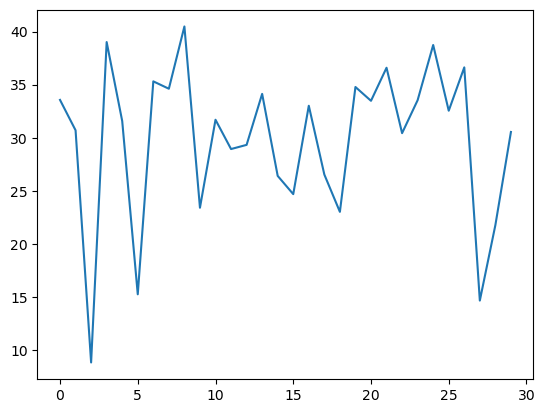

In [34]:
plt.plot(error_20random)

In [25]:
model1 = dq.Qlearner(2+2,[256,256],2,alpha=1e-3)
aprox_perf = []

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-03-30 10:53:48.417360: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-30 10:53:48.419230: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [28]:
for seed in tqdm(range(NEP),desc='Episode'):
    aprox_perf.append([])
    randomizer = np.random
    indices = list(range(NUMBER_SAMPLES-200))
    randomizer.shuffle(indices)
    x_init, y_init = x_o.copy(), y_o.copy() #tf.cast(X_train[indices[:100]],dtype=tf.float32), tf.cast(y_train[indices[:100]],dtype=tf.float32)
    x_cand, y_cand = x_candidates[indices], y_candidates[indices] #tf.cast(X_train[indices[200:]],dtype=tf.float32), tf.cast(y_train[indices[200:]],dtype=tf.float32)
    initial_model = GaussianProcessRegressor()
    initial_model.fit(x_init,y_init)
    usd = 0 
    error_prev = mean_squared_error(y_held,initial_model.predict(x_held))
    for i in tqdm(range(200),desc='State Looping'):
        s_i = state(initial_model,x_cand[i],x_init,y_init)
        a_i = tf.argmax(tf.transpose(model1.compute_qvalue(s_i)))
        if(a_i==1):
            x_init = np.append(x_init,[x_cand[i]],0)
            y_init = np.append(y_init,[y_cand[i]],0)
            usd += 1
            initial_model.fit(x_init,y_init)
            aprox_perf[-1].append(mean_squared_error(y_held,initial_model.predict(x_held)))
        error_current = mean_squared_error(y_held,initial_model.predict(x_held))
        reward = error_prev-error_current
        error_prev = error_current
        if(usd==BUDGET or i==199):
            model1.add_to_memory(s_i,a_i,reward,None)
            break
        else:
            s_ip1 = state(initial_model,x_cand[i+1],x_init,y_init)
            model1.add_to_memory(s_i,a_i,reward,s_ip1)

        if(i>BATCH_SIZE):
            cur_mem = model1.get_current_memory()
            indices = randomizer.randint(len(cur_mem)-1,size=BATCH_SIZE)
            batch_sf = tf.reshape(tf.cast(list( cur_mem[i][3] for i in indices),dtype=tf.float32),[BATCH_SIZE,2+2])
            batch_r = tf.reshape(tf.cast(list( cur_mem[i][2] for i in indices),dtype=tf.float32),[BATCH_SIZE,1])
            batch_si = tf.reshape(tf.cast(list( cur_mem[i][0] for i in indices),dtype=tf.float32),[BATCH_SIZE,2+2])
            batch_ai = tf.reshape(tf.cast(list( cur_mem[i][1] for i in indices),dtype=tf.float32),[BATCH_SIZE,1])
            ys = model1.y_value(batch_sf,batch_r )
            model1.Training_network(ys,batch_ai,batch_si)
    model1.finish_episode()
            

Episode:   0%|          | 0/10 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

Text(0.5, 0, 'Number of candidate points added')

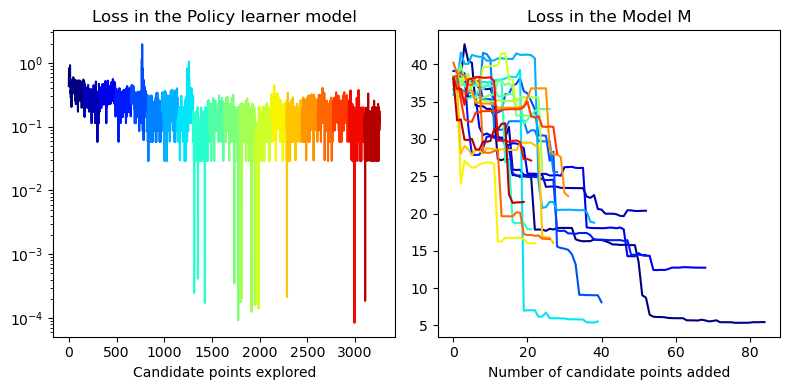

In [29]:
fig, ax = plt.subplots(1,2,tight_layout=True,figsize=(8,4))
l_old = 0
for i in range(len(model1.loss_curve)-1):
    ll = model1.loss_curve[i]
    ax[0].plot(range(l_old,l_old+len(ll)),ll,'-',label='Episode %i'%i,c=plt.cm.jet(i/model1.current_episode))
    l_old += len(ll) 
#ax[0].legend(loc=0)
ax[0].set_yscale('log')

for i in range(model1.current_episode):
    ax[1].plot(aprox_perf[i],c=plt.cm.jet(i/model1.current_episode))

ax[0].set_title('Loss in the Policy learner model')
ax[0].set_xlabel("Candidate points explored")
ax[1].set_title("Loss in the Model M")
ax[1].set_xlabel("Number of candidate points added")


Text(0.5, 0.01, 'Episodes of policy training')

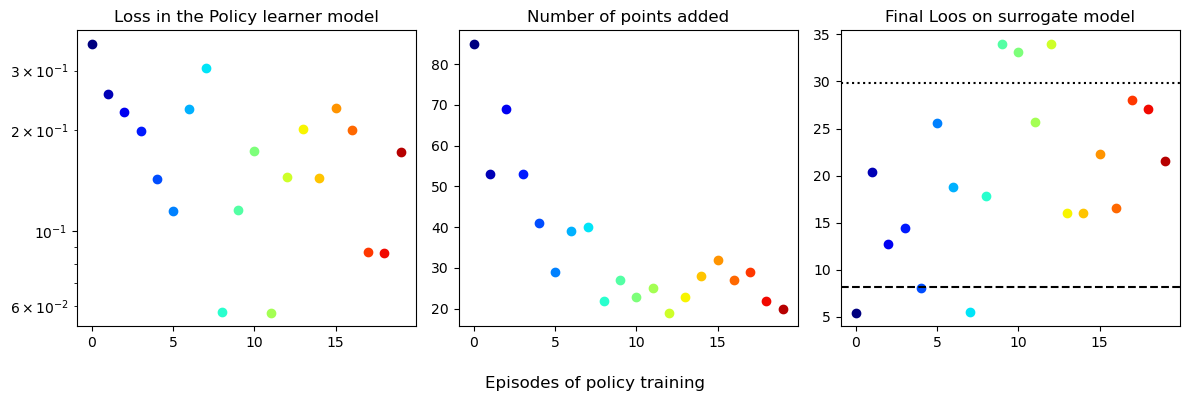

In [35]:
fig, ax = plt.subplots(1,3,tight_layout=True,figsize=(12,4))
l_old = 0
for i in range(model1.current_episode):
    ax[0].plot(i,model1.loss_curve[i][-1],'o',label='Episode %i'%i,c=plt.cm.jet(i/model1.current_episode))
#ax[0].legend(loc=0)
ax[0].set_yscale('log')

for i in range(model1.current_episode):
    ax[1].plot(i,len(aprox_perf[i]),'o',c=plt.cm.jet(i/model1.current_episode))

for i in range(model1.current_episode):
    ax[2].plot(i,aprox_perf[i][-1],'o',c=plt.cm.jet(i/model1.current_episode))

ax[0].set_title('Loss in the Policy learner model')
ax[1].set_title("Loss in the Model M")
ax[1].set_title("Number of points added")
ax[2].set_title('Final Loos on surrogate model')
ax[2].axhline(np.mean(error_random),color='k',linestyle='--')
ax[2].axhline(np.mean(error_20random),color='k',linestyle=':')
fig.supxlabel('Episodes of policy training')

# And another simulation with the heuristics

In [38]:
x_o, y_o = X_train[:100], y_train[:100]
x_held, y_held = X_train[100:200], y_train[100:200]
x_candidates, y_candidates = X_train[200:], y_train[200:]

model2 = dq.Qlearner(2+4,[256,256],2,alpha=1e-2)
aprox_perf = []

In [42]:
for seed in tqdm(range(10),desc='Episode'):
    aprox_perf.append([])
    randomizer = np.random
    indices = list(range(NUMBER_SAMPLES-200))
    randomizer.shuffle(indices)
    x_init, y_init = x_o.copy(), y_o.copy() #tf.cast(X_train[indices[:100]],dtype=tf.float32), tf.cast(y_train[indices[:100]],dtype=tf.float32)
    x_cand, y_cand = x_candidates[indices], y_candidates[indices] #tf.cast(X_train[indices[200:]],dtype=tf.float32), tf.cast(y_train[indices[200:]],dtype=tf.float32)
    initial_model = GaussianProcessRegressor()#RandomForestRegressor(100, n_jobs=-2,random_state=158)
    initial_model.fit(x_init,y_init)
    usd = 0 
    error_prev = mean_squared_error(y_held,initial_model.predict(x_held))
    for i in tqdm(range(200),desc='State Looping'):
        s_i = state_her(initial_model,x_cand[i],fstar)
        a_i = tf.argmax(tf.transpose(model2.compute_qvalue(s_i)))
        if(a_i==1):
            x_init = np.append(x_init,[x_cand[i]],0)
            y_init = np.append(y_init,[y_cand[i]],0)
            usd += 1
            initial_model.fit(x_init,y_init)
            aprox_perf[-1].append(mean_squared_error(y_held,initial_model.predict(x_held)))
        error_current = mean_squared_error(y_held,initial_model.predict(x_held))
        reward = error_prev-error_current
        error_prev = error_current
        if(usd==BUDGET or i==199):
            model2.add_to_memory(s_i,a_i,reward,None)
            break
        else:
            s_ip1 = state_her(initial_model,x_cand[i+1],fstar)
            model2.add_to_memory(s_i,a_i,reward,s_ip1)

        if(i>BATCH_SIZE):
            cur_mem = model2.get_current_memory()
            indices = randomizer.randint(len(cur_mem)-1,size=BATCH_SIZE)
            batch_sf = tf.reshape(tf.cast(list( cur_mem[i][3] for i in indices),dtype=tf.float32),[BATCH_SIZE,2+4])
            batch_r = tf.reshape(tf.cast(list( cur_mem[i][2] for i in indices),dtype=tf.float32),[BATCH_SIZE,1])
            batch_si = tf.reshape(tf.cast(list( cur_mem[i][0] for i in indices),dtype=tf.float32),[BATCH_SIZE,2+4])
            batch_ai = tf.reshape(tf.cast(list( cur_mem[i][1] for i in indices),dtype=tf.float32),[BATCH_SIZE,1])
            ys = model2.y_value(batch_sf,batch_r )
            model2.Training_network(ys,batch_ai,batch_si)
    model2.finish_episode()

Episode:   0%|          | 0/10 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

Text(0.5, 0, 'Number of candidate points added')

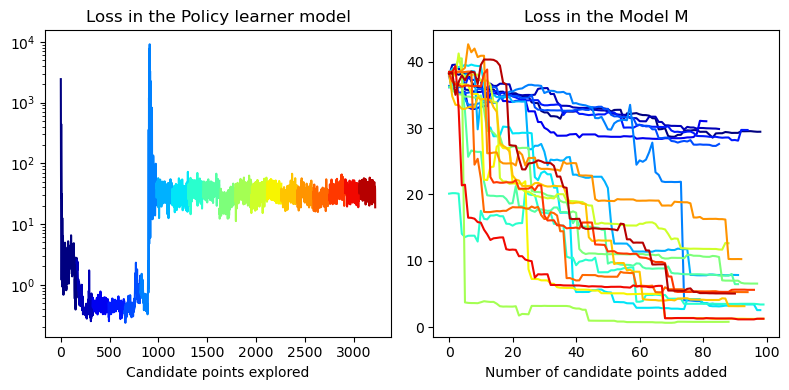

In [43]:
fig, ax = plt.subplots(1,2,tight_layout=True,figsize=(8,4))
l_old = 0
for i in range(len(model2.loss_curve)-1):
    ll = model2.loss_curve[i]
    ax[0].plot(range(l_old,l_old+len(ll)),ll,'-',label='Episode %i'%i,c=plt.cm.jet(i/model2.current_episode))
    l_old += len(ll) 
#ax[0].legend(loc=0)
ax[0].set_yscale('log')

for i in range(model2.current_episode):
    ax[1].plot(aprox_perf[i],c=plt.cm.jet(i/model2.current_episode))

ax[0].set_title('Loss in the Policy learner model')
ax[0].set_xlabel("Candidate points explored")
ax[1].set_title("Loss in the Model M")
ax[1].set_xlabel("Number of candidate points added")

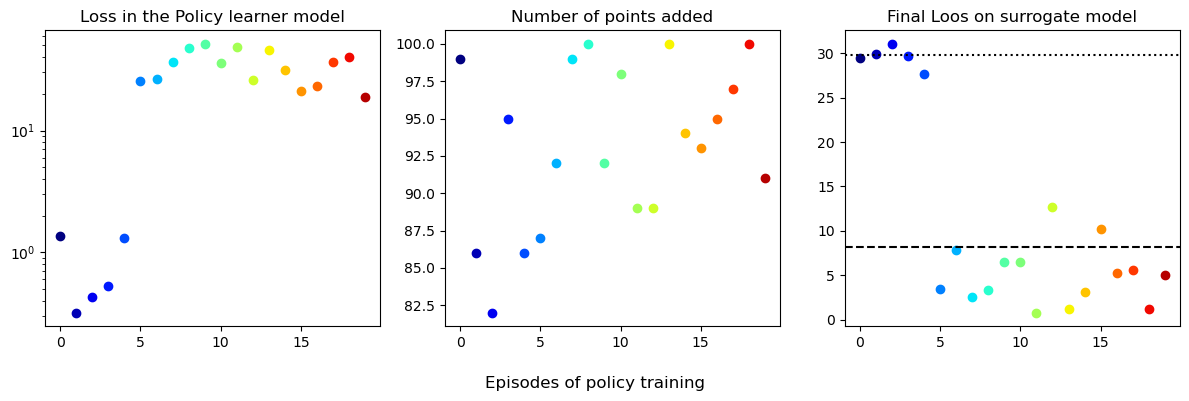

In [45]:
fig, ax = plt.subplots(1,3,tight_layout=True,figsize=(12,4))
l_old = 0
for i in range(model2.current_episode):
    ax[0].plot(i,model2.loss_curve[i][-1],'o',label='Episode %i'%i,c=plt.cm.jet(i/model2.current_episode))
#ax[0].legend(loc=0)
ax[0].set_yscale('log')

for i in range(model2.current_episode):
    ax[1].plot(i,len(aprox_perf[i]),'o',c=plt.cm.jet(i/model2.current_episode))

for i in range(model2.current_episode):
    ax[2].plot(i,aprox_perf[i][-1],'o',c=plt.cm.jet(i/model2.current_episode))

ax[0].set_title('Loss in the Policy learner model')
ax[1].set_title("Loss in the Model M")
ax[1].set_title("Number of points added")
ax[2].set_title('Final Loos on surrogate model')
fig.supxlabel('Episodes of policy training')
ax[2].axhline(np.mean(error_random),color='k',linestyle='--')
ax[2].axhline(np.mean(error_20random),color='k',linestyle=':')

# Fixing the decay rate

In [46]:
import importlib as il

In [49]:
il.reload(dq)

<module 'MultiLayerDQTF' from '/Users/tingua/Documents/2023 Spring/Merck 2023 Spring/MultiLayerDQTF.py'>

In [10]:
x_o, y_o = X_train[:100], y_train[:100]
x_held, y_held = X_train[100:200], y_train[100:200]
x_candidates, y_candidates = X_train[200:], y_train[200:]

model2 = dq.Qlearner(2+4,[256,256],2,alpha=1e-2,decay_rate=0.999,decay_steps=1000)
aprox_perf = []

In [11]:
for seed in tqdm(range(10),desc='Episode'):
    aprox_perf.append([])
    randomizer = np.random
    indices = list(range(NUMBER_SAMPLES-200))
    randomizer.shuffle(indices)
    x_init, y_init = x_o.copy(), y_o.copy() #tf.cast(X_train[indices[:100]],dtype=tf.float32), tf.cast(y_train[indices[:100]],dtype=tf.float32)
    x_cand, y_cand = x_candidates[indices], y_candidates[indices] #tf.cast(X_train[indices[200:]],dtype=tf.float32), tf.cast(y_train[indices[200:]],dtype=tf.float32)
    initial_model = GaussianProcessRegressor()#RandomForestRegressor(100, n_jobs=-2,random_state=158)
    initial_model.fit(x_init,y_init)
    usd = 0 
    error_prev = mean_squared_error(y_held,initial_model.predict(x_held))
    for i in tqdm(range(200),desc='State Looping'):
        s_i = state_her(initial_model,x_cand[i],fstar)
        a_i = tf.argmax(tf.transpose(model2.compute_qvalue(s_i)))
        if(a_i==1):
            x_init = np.append(x_init,[x_cand[i]],0)
            y_init = np.append(y_init,[y_cand[i]],0)
            usd += 1
            initial_model.fit(x_init,y_init)
            aprox_perf[-1].append(mean_squared_error(y_held,initial_model.predict(x_held)))
        error_current = mean_squared_error(y_held,initial_model.predict(x_held))
        reward = error_prev-error_current
        error_prev = error_current
        if(usd==BUDGET or i==199):
            model2.add_to_memory(s_i,a_i,reward,None)
            break
        else:
            s_ip1 = state_her(initial_model,x_cand[i+1],fstar)
            model2.add_to_memory(s_i,a_i,reward,s_ip1)

        if(i>BATCH_SIZE):
            cur_mem = model2.get_current_memory()
            indices = randomizer.randint(len(cur_mem)-1,size=BATCH_SIZE)
            batch_sf = tf.reshape(tf.cast(list( cur_mem[i][3] for i in indices),dtype=tf.float32),[BATCH_SIZE,2+4])
            batch_r = tf.reshape(tf.cast(list( cur_mem[i][2] for i in indices),dtype=tf.float32),[BATCH_SIZE,1])
            batch_si = tf.reshape(tf.cast(list( cur_mem[i][0] for i in indices),dtype=tf.float32),[BATCH_SIZE,2+4])
            batch_ai = tf.reshape(tf.cast(list( cur_mem[i][1] for i in indices),dtype=tf.float32),[BATCH_SIZE,1])
            ys = model2.y_value(batch_sf,batch_r )
            model2.Training_network(ys,batch_ai,batch_si)
    model2.finish_episode()

Episode:   0%|          | 0/10 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

2023-03-30 11:43:40.281548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-30 11:43:40.341999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-30 11:43:40.374703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-30 11:43:40.540789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
fig, ax = plt.subplots(1,2,tight_layout=True,figsize=(8,4))
l_old = 0
for i in range(len(model2.loss_curve)-1):
    ll = model2.loss_curve[i]
    ax[0].plot(range(l_old,l_old+len(ll)),ll,'-',label='Episode %i'%i,c=plt.cm.jet(i/model2.current_episode))
    l_old += len(ll) 
#ax[0].legend(loc=0)
ax[0].set_yscale('log')

for i in range(model2.current_episode):
    ax[1].plot(aprox_perf[i],c=plt.cm.jet(i/model2.current_episode))

ax[0].set_title('Loss in the Policy learner model')
ax[0].set_xlabel("Candidate points explored")
ax[1].set_title("Loss in the Model M")
ax[1].set_xlabel("Number of candidate points added")

# Random Benchmark

In [21]:
model3 = dq.Qlearner(12,81,2)
approx_perf3 = []

In [23]:
for seed in tqdm(seeds,desc='Episode'):
    approx_perf3.append([])
    randomizer = np.random
    indices = list(range(NUMBER_SAMPLES-200))
    randomizer.shuffle(indices)
    x_init, y_init = x_o.copy(), y_o.copy() #tf.cast(X_train[indices[:100]],dtype=tf.float32), tf.cast(y_train[indices[:100]],dtype=tf.float32)
    x_cand, y_cand = x_candidates[indices], y_candidates[indices] #tf.cast(X_train[indices[200:]],dtype=tf.float32), tf.cast(y_train[indices[200:]],dtype=tf.float32)
    initial_model = RandomForestRegressor(100, n_jobs=-2,random_state=158)
    initial_model.fit(x_init,y_init)
    usd = 0 
    error_prev = mean_squared_error(y_held,initial_model.predict(x_held))
    for i in tqdm(range(200),desc='State Looping'):
        s_i = state(initial_model,x_cand[i],x_init,y_init)
        a_i = np.random.randint(2)#tf.argmax(tf.transpose(model1.compute_qvalue(s_i)))
        if(a_i==1):
            x_init = np.append(x_init,[x_cand[i]],0)
            y_init = np.append(y_init,[y_cand[i]],0)
            usd += 1
            initial_model.fit(x_init,y_init)
            approx_perf3[-1].append(mean_squared_error(y_held,initial_model.predict(x_held)))
        error_current = mean_squared_error(y_held,initial_model.predict(x_held))
        reward = error_prev-error_current
        error_prev = error_current
        if(usd==BUDGET or i==199):
            model3.add_to_memory(s_i,a_i,reward,None)
            break
        else:
            s_ip1 = state(initial_model,x_cand[i+1],x_init,y_init)
            model3.add_to_memory(s_i,a_i,reward,s_ip1)

        if(i>BATCH_SIZE):
            cur_mem = model3.get_current_memory()
            indices = randomizer.randint(len(cur_mem)-1,size=BATCH_SIZE)
            batch_sf = tf.reshape(tf.cast(list( cur_mem[i][3] for i in indices),dtype=tf.float32),[BATCH_SIZE,12])
            batch_r = tf.reshape(tf.cast(list( cur_mem[i][2] for i in indices),dtype=tf.float32),[BATCH_SIZE,1])
            batch_si = tf.reshape(tf.cast(list( cur_mem[i][0] for i in indices),dtype=tf.float32),[BATCH_SIZE,12])
            batch_ai = tf.reshape(tf.cast(list( cur_mem[i][1] for i in indices),dtype=tf.float32),[BATCH_SIZE,1])
            ys = model3.y_value(batch_sf,batch_r )
            model3.Training_network(ys,batch_ai,batch_si)
    model3.finish_episode()

Episode:   0%|          | 0/2 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

Text(0.5, 0, 'Candidate points added to the initial training data set')

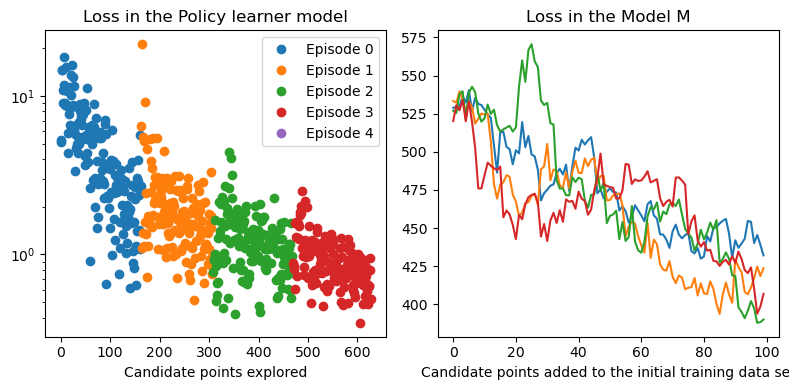

In [26]:
fig, ax = plt.subplots(1,2,tight_layout=True,figsize=(8,4))
l_old = 0
for i in range(len(model3.loss_curve)):
    ll = model3.loss_curve[i]
    ax[0].plot(range(l_old,l_old+len(ll)),ll,'o',label='Episode %i'%i)
    l_old += len(ll) 
ax[0].legend(loc=0)
ax[0].set_yscale('log')

for i in range(model3.current_episode):
    ax[1].plot(approx_perf3[i])

ax[0].set_title('Loss in the Policy learner model')
ax[0].set_xlabel("Candidate points explored")
ax[1].set_title("Loss in the Model M")
ax[1].set_xlabel("Candidate points added to the initial training data set")
